# Анализ поведения пользователей мобильного приложения

**Задача:** На основе данных использования мобильного приложения для продажи продуктов питания проанализировать воронку продаж, а также оценить результаты A/A/B-тестирования

<a name='content'></a>
## Оглавление 
[Подготовка данных](#preprocessing)
- [Импорт библиотек](#import)
- [Загрузка и предобработка данных](#download)

[Проверка данных](#check)
- [Число событий в логе](#events_number)
- [Число пользователей в логе](#number_users)
- [Среднее число событий на одного пользователя](#mean_users)
- [Анализ периода сбора данных](#data_period)
- [Гистограмма количества событий по дате и времени](#event_days)
- [Проверка числа пользователей в группах](#group_check)

[Воронка событий](#funnel)
 - [События в логах и их частота](#funnel_analysis)
 - [Количество пользователей по событиям](#event_user)
 - [Визуализация воронки событий и анализ потерь на каждом этапе](#funnel_user)
 - [Анализ воронки событий по группам](#user_group_event)
 

[Сравнение групп](#group_compare)
- [Число пользователей в каждой группе](#user_event_group)
- [Достоверность разницы в группах (для пользователей, которые последовательно прошли все этапы)](#group_dif)
- [Достоверность разницы в группах (для всех пользователей)](#group_dif2)

[Общий вывод](#result)

<a name = 'preprocessing'></a>
## Подготовка данных

<a name = 'import'></a>
### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
import plotly.express as px
from plotly import graph_objects as go
from statsmodels.stats.proportion import proportions_ztest

[К оглавлению](#content)

<a id = 'download'></a>
### Загрузка и предобработка данных

In [2]:
url = 'logs_exp.csv'
data = pd.read_csv(url, sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Пропущенных значений нет, названия столбцов нужно привести одному регистру, тип столбца EventTimestamp привести к типу datetime

In [4]:
# изменение названия столбцов
data = data.rename(columns={'EventName' : 'event', 'DeviceIDHash' : 'user', 
                            'EventTimestamp' : 'event_time', 'ExpId' : 'group'})

In [5]:
# проверка на дубликаты
print('Число дубликатов:', data.duplicated().sum())

Число дубликатов: 413


In [6]:
# удаление дубликатов
data = data.drop_duplicates()

In [7]:
# создание столбца datetime
data['date_time'] = pd.to_datetime(data.event_time, unit = 's')
data['date'] = data.date_time.dt.date.astype("datetime64")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       243713 non-null  object        
 1   user        243713 non-null  int64         
 2   event_time  243713 non-null  int64         
 3   group       243713 non-null  int64         
 4   date_time   243713 non-null  datetime64[ns]
 5   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


В результате предобработки данных были удалены дубликаты, изменены названия солбцов и созданы два дополнительных столбца: с датой/временем события и с датой события.

#### Проверка пересечений пользователей в группах

In [8]:
def same_user(group1, group2):
    same_visitors = (set(data[data['group'] == group1]['user']
                    .unique()).intersection(data[data['group'] == group2]['user'].unique()))
    return len(same_visitors)

print('Пересечение пользователей в группах 246 и 247: ', same_user(246, 247))
print('Пересечение пользователей в группах 246 и 248: ', same_user(246, 248))
print('Пересечение пользователей в группах 2467 и 248: ', same_user(247, 248))

Пересечение пользователей в группах 246 и 247:  0
Пересечение пользователей в группах 246 и 248:  0
Пересечение пользователей в группах 2467 и 248:  0


Пользователи в группах не пересекаются 

[К оглавлению](#content)

<a id='check'></a>
## Проверка данных

<a id='events_number'></a>
### Число событий в логе

In [9]:
number_events = data.event.count()
print('Число событий в логе: ', number_events)

Число событий в логе:  243713


In [10]:
print('Названия уникальных событий в логе: ', data.event.unique())

Названия уникальных событий в логе:  ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


[К оглавлению](#content)

<a id='number_users'></a>
### Число пользователей в логе

In [11]:
number_users = data.user.nunique()
print('Число уникальных пользователей в логе: ', number_users)

Число уникальных пользователей в логе:  7551


[К оглавлению](#content)

<a id='mean_users'></a>
### Среднее число событий на одного пользователя


In [12]:
events_by_user = data.groupby('user', as_index = False).agg({'event': 'count'})

display(events_by_user.event.describe())

print('Среднее число событий на одного пользователя: ', round(events_by_user.event.mean(), 2))
print('Медианное число событий на одного пользователя: ', round(events_by_user.event.median(), 2))

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event, dtype: float64

Среднее число событий на одного пользователя:  32.28
Медианное число событий на одного пользователя:  20.0


Медиана и среднее сильно отличаются друг от друга. Стоить проверить характер распределения 

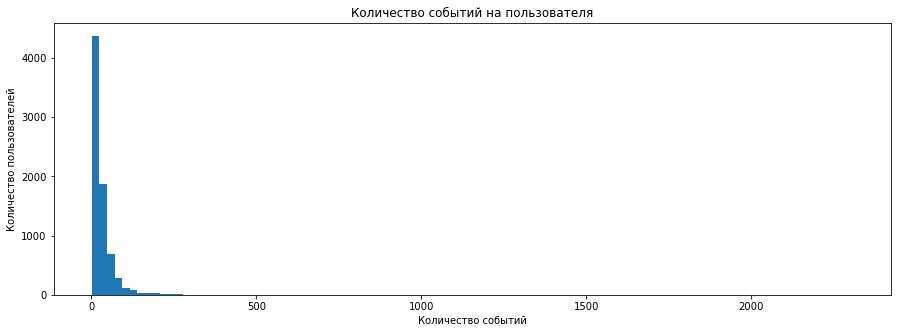

In [13]:
# гистограмма распределения числа пользователей и числа событий
plt.figure(figsize=(15,5))
plt.hist(events_by_user.event, bins=100) 
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.title('Количество событий на пользователя')
plt.show()

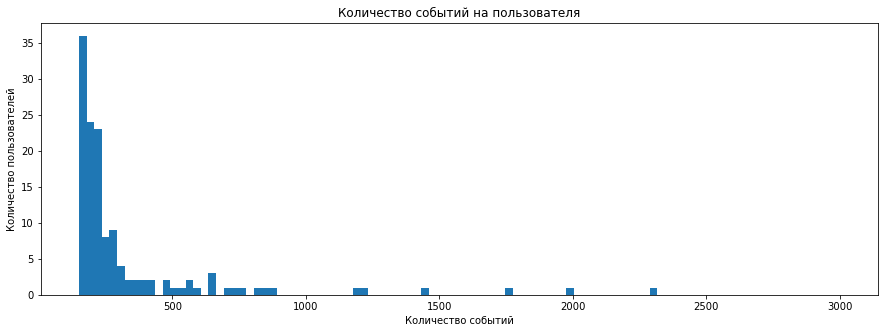

In [14]:
plt.figure(figsize=(15,5))
plt.hist(events_by_user.event, bins=100, range = (150, 3000)) 
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.title('Количество событий на пользователя')
plt.show()

Распределение количества событий по количеству пользователей - экспоненциальное, с выбросами (присутствуют пользователи с аномально большим количеством событий)

In [15]:
np.percentile(events_by_user.event, [95, 99])

array([ 89. , 200.5])

95% пользователей совершали более 89 событий, 1% более 200. Отфильтруем пользователей, которые совершали больше 200 событий

In [16]:
delete_user_list = events_by_user.query('event > 200').user.to_list()
data = data.query('user not in @delete_user_list')

events_by_user = data.groupby('user', as_index = False).agg({'event': 'count'})

display(events_by_user.event.describe())

print('Среднее число событий на одного пользователя: ', round(events_by_user.event.mean(), 2))
print('Медианное число событий на одного пользователя: ', round(events_by_user.event.median(), 2))

count    7475.000000
mean       28.004415
std        27.798365
min         1.000000
25%         9.000000
50%        19.000000
75%        37.000000
max       199.000000
Name: event, dtype: float64

Среднее число событий на одного пользователя:  28.0
Медианное число событий на одного пользователя:  19.0


[К оглавлению](#content)

<a id='data_period'></a>
### Анализ периода сбора данныx

In [17]:
print('Минимальная дата: ', data.date.min())
print('Максимальная дата: ', data.date.max())
print('Период сбора данных: ', data.date.max() - data.date.min())

Минимальная дата:  2019-07-25 00:00:00
Максимальная дата:  2019-08-07 00:00:00
Период сбора данных:  13 days 00:00:00


[К оглавлению](#content)

<a id='event_days'></a>
### Гистограмма количества событий по дате и времени

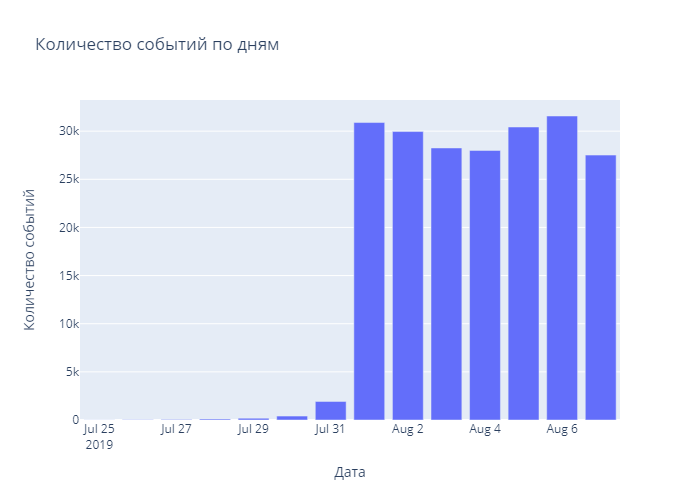

,date,event
0,2019-07-25,9
1,2019-07-26,29
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,411
6,2019-07-31,1925
7,2019-08-01,30894
8,2019-08-02,29958
9,2019-08-03,28252


In [18]:
# Количество событий по дням
data_time = data.groupby('date', as_index = False).agg({'event': 'count'})

fig = px.bar(data_time, x='date', y='event', title="Количество событий по дням", 
             labels={'date':'Дата', 'event': 'Количество событий'})
fig.show("png")

data_time

Данные были собраны в течение 13 дней. При этом, за июль количество собранных данных или активность пользователей существенно ниже, чем за август

In [19]:
# количество событий до 1го августа
print('За июль произошло', 
      round(data.query('date < "2019-08-01"')['event'].count() / data.event.count() * 100, 1).astype('str') + '%', 
     'всех событий')

За июль произошло 1.3% всех событий


Таким образом, в июле произошло всего 1.2% всех событий. Полными данные можно считать только за август. Сбор данных в августе происходил в течение 7 дней. 

In [20]:
# новый датасет, начиная с 1го августа включительно
data_f = data.query('date >= "2019-08-01"')

#### Количество отфильтрованных пользователей

In [21]:
print('Количество отфильтрованных пользователей: ', data.user.nunique() - data_f.user.nunique())

Количество отфильтрованных пользователей:  17


[К оглавлению](#content)

<a id='group_check'></a>
### Проверка числа пользователей в группах

In [22]:
# проверка числа пользователей в группах
data_f.group.value_counts()

248    70908
247    68295
246    67412
Name: group, dtype: int64

В новом датасете присутсвуют пользователи во всех группах, размеры групп сопоставимы

<b>Вывод:</b> число пользователей в логе - 7551. Распределение количества событий по количеству пользователей - экспоненциальное (есть выбросы - присутствуют пользователи с аномально большим количеством событий). После фильтрации аномалий, среднее число событий на одного пользователя - 24.76, медианное - 19. 


В логе 5 уникальных событий: 
1. MainScreenAppear - появление главного экрана - Пользователь зашел на сайт
2. OffersScreenAppear - появление экрана предложений - Пользователь искал товар по каталогу
3. CartScreenAppear - появление экрана корзины - Пользователь добавил товар в корзину
4. PaymentScreenSuccessful - экран платеж успешен - Пользователь оплатил товар 
5. Tutorial - руководство пользователя - Пользователь изучал инструкцию

Данные собирались в течение 13 дней. При этом, за июль количество собранных данных или активность пользователей существенно ниже, чем за август - в июле произошло всего 1.2% всех событий. Данные за июль были отфильтрованы из датасета. В новом датасете есть пользователи во всех группах, размеры групп сопоставимы

[К оглавлению](#content)

<a id='funnel'></a>
## Воронка событий

<a id='funnel_analysis'></a>
### События в логах и их частота

In [23]:
# события в логах их частота
data_f.event.value_counts()

MainScreenAppear           113264
OffersScreenAppear          40956
CartScreenAppear            29250
PaymentScreenSuccessful     22164
Tutorial                      981
Name: event, dtype: int64

[К оглавлению](#content)

<a id='event_user'></a>
### Количество пользователей по событиям

In [24]:
# число пользователей, совершавших событие
data_event_users = (data_f.groupby('event', as_index = False)
                    .agg({'user': 'nunique'})
                    .sort_values(by = 'user', ascending = False))

# доля пользователей, совершавших событие
count_users = data_f.user.nunique()
data_event_users['percentage'] = round(data_event_users.user / count_users * 100, 1).astype('str') + '%'

data_event_users

,event,user,percentage
1,MainScreenAppear,7344,98.5%
2,OffersScreenAppear,4517,60.6%
0,CartScreenAppear,3658,49.0%
3,PaymentScreenSuccessful,3463,46.4%
4,Tutorial,824,11.0%


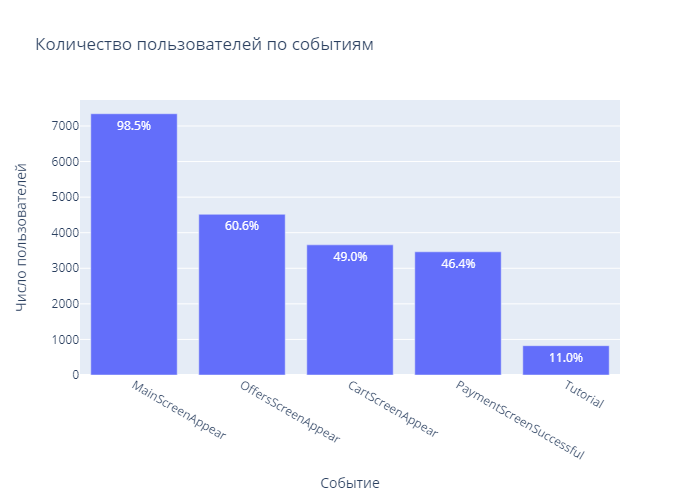

In [25]:
fig = px.bar(data_event_users, x='event', y='user', title="Количество пользователей по событиям", 
             labels={'event':'Событие', 'user': 'Число пользователей'},
             text = 'percentage')
fig.show("png")

Самое частое событие - MainScreenAppear (98.5%), самое редкое - Tutorial (11.1%)

События происходят в следующем порядке: 
1. MainScreenAppear - появление главного экрана - Пользователь зашел на сайт
2. OffersScreenAppear - появление экрана предложений - Пользователь искал товар по каталогу
3. CartScreenAppear - появление экрана корзины - Пользователь добавил товар в корзину
4. PaymentScreenSuccessful - экран платеж успешен - Пользователь оплатил товар (целевое действие)

Событие Tutorial - руководство пользователя - может произойти на любом этапе и не входит в цепочку событий от захода на сайт до совершения покупки. Данное событие не будет учитываться при расчете воронки

То, что событие MainScreenAppear присутствует только у 98.5% пользователей говорит о том, что часть пользователей проходила воронку событий не с первого этапа. 

[К оглавлению](#content)

<a id='funnel_user'></a>
### Визуализация воронки событий и анализ потерь на каждом этапе

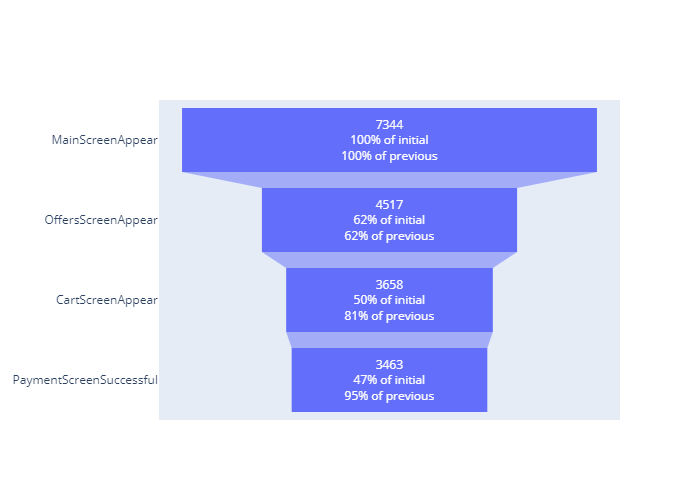

In [26]:
# воронка событий
fig = go.Figure(go.Funnel(x = data_event_users.query('event != "Tutorial"').user, 
                          y = data_event_users.query('event != "Tutorial"').event, 
                          textinfo = "value+percent initial+percent previous"))
fig.show("png")

Больше всего пользователей теряется на этапе MainScreenAppear - OffersScreenAppear (38%). Меньше всего теряется пользователей на этапе CartScreenAppear - PaymentScreenSuccessful (5%)

Конверсия оплаты от захода на сайт неправдоподобно высокая - 48%. Это может быть связано с тем, что часть пользователей проходила воронку событий не с первого этапа. Отфильтруем пользователей, которые прошли последовательно все этапы: 

In [27]:
# воронка пользователей, которые последовательно прошли все события воронки (от первого до оплаты)
data_clear_users = pd.pivot_table(data_f.query('event != "Tutorial"'), 
                                  values='date_time', 
                                  aggfunc='min',
                                  index=['user', 'group'], 
                                  columns = 'event').reset_index()

group_1 = data_clear_users.dropna(subset = ['MainScreenAppear'])
group_2 = group_1.query('MainScreenAppear < OffersScreenAppear')
group_3 = group_2.query('OffersScreenAppear < CartScreenAppear')
group_4 = group_3.query('CartScreenAppear < PaymentScreenSuccessful')

data_clear_users_table = pd.DataFrame(columns = ['event', 'user'], data = [
    ['MainScreenAppear',group_1.user.count()],
    ['OffersScreenAppear',group_2.user.count()],
    ['CartScreenAppear',group_3.user.count()],
    ['PaymentScreenSuccessful',group_4.user.count()]
])

data_clear_users_table

,event,user
0,MainScreenAppear,7344
1,OffersScreenAppear,4140
2,CartScreenAppear,1729
3,PaymentScreenSuccessful,440


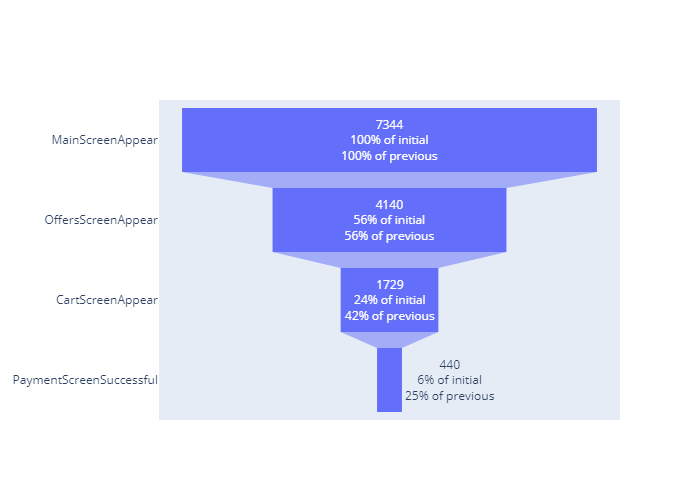

In [28]:
fig = go.Figure(go.Funnel(x = data_clear_users_table.user, 
                          y = data_clear_users_table.event, 
                          textinfo = "value+percent initial+percent previous"))
fig.show("png")

После фильтрации воронка существенно изменилась: конверсия захода на сайт в покупку составляет 6%, самая большая потеря пользователей происходит на этапе оплаты - 75% от предыдущего этапа.

[К оглавлению](#content)

<a id='user_group_event'></a>
### Анализ воронки событий по группам

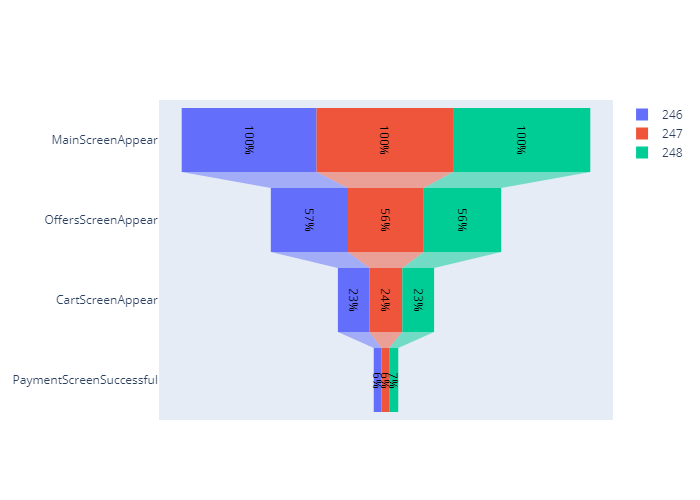

In [29]:
# воронка пользователей, которые последовательно прошли все этапы по группам
group_1_by_group = group_1.groupby('group', as_index = False).agg({'user': 'count'})
group_2_by_group = group_2.groupby('group', as_index = False).agg({'user': 'count'})
group_3_by_group = group_3.groupby('group', as_index = False).agg({'user': 'count'})
group_4_by_group = group_4.groupby('group', as_index = False).agg({'user': 'count'})

data_clear_users_by_group = group_1_by_group.merge(group_2_by_group, on='group', suffixes=('_1', '_2'))
data_clear_users_by_group = data_clear_users_by_group.merge(group_3_by_group, on='group', suffixes=('_2', '_3'))
data_clear_users_by_group = data_clear_users_by_group.merge(group_4_by_group, on='group', suffixes=('_3', '_4'))

data_clear_users_by_group.columns = ['group', 'MainScreenAppear', 
                                           'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

groups = data_clear_users_by_group.group.unique()

fig = go.Figure()
for i in [0, 1, 2]:
    fig.add_trace(go.Funnel(
        name = groups[i].astype('str'),
        y = data_clear_users_table.event.tolist(),
        x = data_clear_users_by_group[data_clear_users_by_group.group == groups[i]].iloc[0].tolist()[1:5],
        textposition = "inside",
        textinfo = "percent initial",
        constraintext='outside',
        textangle = 90,
        insidetextfont = {'color': 'black'}))

fig.show("png")

<b>Вывод:</b> самое частое событие - MainScreenAppear (98.5%), самое редкое - Tutorial (11.1%)

События происходят в следующем порядке: 
1. MainScreenAppear - появление главного экрана - Пользователь зашел на сайт
2. OffersScreenAppear - появление экрана предложений - Пользователь искал товар по каталогу
3. CartScreenAppear - появление экрана корзины - Пользователь добавил товар в корзину
4. PaymentScreenSuccessful - экран платеж успешен - Пользователь оплатил товар (целевое действие)

Событие Tutorial - руководство пользователя - может произойти на любом этапе и не входит в цепочку событий от захода на сайт до совершения покупки. Данное событие не будет учитываться при расчете воронки

Больше всего пользователей теряется на этапе MainScreenAppear - OffersScreenAppear (38%). Меньше всего теряется пользователей на этапе CartScreenAppear - PaymentScreenSuccessful (5%). Конверсия оплаты от захода на сайт неправдоподобно высокая - 48%. Это может быть связано с тем, что часть пользователей проходила воронку событий не с первого этапа. Отфильтруем пользователей, которые прошли последовательно все этапы: 

После фильтрации воронка существенно изменилась: конверсия захода на сайт в покупку составляет 6%, самая большая потеря пользователей происходит на этапе оплаты - 75%.

[К оглавлению](#content)

<a id='group_compare'></a>
## Сравнение групп

<a id='user_event_group'></a>
### Число пользователей в каждой группе

In [30]:
data_clear_users_by_group['user'] = data_clear_users_by_group['MainScreenAppear']
data_clear_users_by_group

,group,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,user
0,246,2423,1387,569,138,2423
1,247,2454,1362,589,140,2454
2,248,2467,1391,571,162,2467


In [31]:
# создание объединенной группы
united_row = ['246_247',
              data_clear_users_by_group.query('group == 246')['MainScreenAppear'].iloc[0]  + data_clear_users_by_group.query('group == 247')['MainScreenAppear'].iloc[0] , 
              data_clear_users_by_group.query('group == 246')['OffersScreenAppear'].iloc[0]  + data_clear_users_by_group.query('group == 247')['OffersScreenAppear'].iloc[0] , 
              data_clear_users_by_group.query('group == 246')['CartScreenAppear'].iloc[0]  + data_clear_users_by_group.query('group == 247')['CartScreenAppear'].iloc[0] , 
              data_clear_users_by_group.query('group == 246')['PaymentScreenSuccessful'].iloc[0]  + data_clear_users_by_group.query('group == 247')['PaymentScreenSuccessful'].iloc[0],
              data_clear_users_by_group.query('group == 246')['user'].iloc[0]  + data_clear_users_by_group.query('group == 247')['user'].iloc[0] 
           ]
data_clear_users_by_group.loc[3] = united_row
data_clear_users_by_group

,group,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,user
0,246,2423,1387,569,138,2423
1,247,2454,1362,589,140,2454
2,248,2467,1391,571,162,2467
3,246_247,4877,2749,1158,278,4877


[К оглавлению](#content)

<a id='group_dif'></a>
## Достоверность разницы в группах (для пользователей, которые последовательно прошли все этапы)

Для расчета достоверности разницы в группах будет использоваться z-test. Будут проанализированы пользователи, которые прошли последовательно все этапы. Потому событие MainScreenAppear проанализировано не будет - это первый этап, который прошли 100% всех пользователей во всех группах

In [32]:
# z-test
def z_test(data, group_1, group_2, alpha, events):
    for item in events:
        count = np.array([data.query('group == @group_1')[item].iloc[0], data.query('group == @group_2')[item].iloc[0]])
        nobs = np.array([data.query('group == @group_1')['user'].iloc[0], data.query('group == @group_2')['user'].iloc[0]])
        stat, p_value = proportions_ztest(count, nobs)
        print('Событие {} p-значение: {}'.format(item, round(p_value, 3)))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
            print(' ')

### А/А тест: разница между двумя контрольными группами

In [33]:
z_test(data_clear_users_by_group, 246, 247, 0.01, ['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'])

Событие OffersScreenAppear p-значение: 0.22
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие CartScreenAppear p-значение: 0.671
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие PaymentScreenSuccessful p-значение: 0.989
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


### А/B тест: разница между контрольной и экспериментальной группой

In [34]:
z_test(data_clear_users_by_group, 246, 248, 0.05, ['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'])

Событие OffersScreenAppear p-значение: 0.544
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие CartScreenAppear p-значение: 0.78
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие PaymentScreenSuccessful p-значение: 0.204
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


In [35]:
z_test(data_clear_users_by_group, 247, 248, 0.05, ['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'])

Событие OffersScreenAppear p-значение: 0.533
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие CartScreenAppear p-значение: 0.479
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие PaymentScreenSuccessful p-значение: 0.208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


### А/B тест: разница между объединенными контрольными и экспериментальной группой

In [36]:
z_test(data_clear_users_by_group, '246_247', 248, 0.05, ['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'])

Событие OffersScreenAppear p-значение: 0.989
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие CartScreenAppear p-значение: 0.568
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие PaymentScreenSuccessful p-значение: 0.139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


<b>Вывод:</b> значимой разницы между группами во всех тестах нет

Количество выполненных проверок - 12.
Корректировка уровня значимости не требуется, во всех тестах уровень значимости значительно выше 5%

[К оглавлению](#content) 

<a id='group_dif'></a>
## Достоверность разницы в группах (для всех пользователей)

In [37]:
data_test = data_f.copy()
data_test = data_test[data_test['event'] != 'Tutorial'].pivot_table(index = 'group', columns = 'event', values = 'user', aggfunc = 'nunique').reset_index()

data_test = data_test.merge(data_f[data_f['event'] != 'Tutorial'].groupby('group')['user'].nunique(), on='group')

united_row_test = ['246_247',
              data_test.query('group == 246')['CartScreenAppear'].iloc[0]  + data_test.query('group == 247')['CartScreenAppear'].iloc[0], 
              data_test.query('group == 246')['MainScreenAppear'].iloc[0]  + data_test.query('group == 247')['MainScreenAppear'].iloc[0], 
              data_test.query('group == 246')['OffersScreenAppear'].iloc[0]  + data_test.query('group == 247')['OffersScreenAppear'].iloc[0], 
              data_test.query('group == 246')['PaymentScreenSuccessful'].iloc[0]  + data_test.query('group == 247')['PaymentScreenSuccessful'].iloc[0],
              data_test.query('group == 246')['user'].iloc[0]  + data_test.query('group == 247')['user'].iloc[0] 
           ]
data_test.loc[3] = united_row_test
data_test

,group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,user
0,246,1238,2423,1514,1172,2455
1,247,1216,2454,1498,1136,2490
2,248,1204,2467,1505,1155,2509
3,246_247,2454,4877,3012,2308,4945


### А/А тест: разница между двумя контрольными группами

In [38]:
z_test(data_test, 246, 247, 0.01, ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'])

Событие MainScreenAppear p-значение: 0.667
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие OffersScreenAppear p-значение: 0.277
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие CartScreenAppear p-значение: 0.263
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие PaymentScreenSuccessful p-значение: 0.136
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


### А/B тест: разница между контрольной и экспериментальной группой

In [39]:
z_test(data_test, 246, 248, 0.05, ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'])

Событие MainScreenAppear p-значение: 0.281
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие OffersScreenAppear p-значение: 0.224
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие CartScreenAppear p-значение: 0.086
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие PaymentScreenSuccessful p-значение: 0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


In [40]:
z_test(data_test, 247, 248, 0.05, ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'])

Событие MainScreenAppear p-значение: 0.515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие OffersScreenAppear p-значение: 0.899
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие CartScreenAppear p-значение: 0.549
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие PaymentScreenSuccessful p-значение: 0.77
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


### А/B тест: разница между объединенными контрольными и экспериментальной группой

In [41]:
z_test(data_test, '246_247', 248, 0.05, ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'])

Событие MainScreenAppear p-значение: 0.312
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие OffersScreenAppear p-значение: 0.439
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие CartScreenAppear p-значение: 0.181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Событие PaymentScreenSuccessful p-значение: 0.601
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


Количество выполненных проверок - 16.
    
Корректировка уровня значимости не требуется, во всех тестах уровень значимости выше 5%
    
<b>Вывод:</b> значимой разницы между группами во всех тестах нет

[К оглавлению](#content) 

<a id='result'></a>
# Общий вывод

В ходе анализа и эксперементов было сделано и выявлено:

В результате предобработки данных были удалены дубликаты, изменены названия солбцов и созданы два дополнительных столбца: с датой/временем события и с датой события. 

Распределение количества событий по количеству пользователей - экспоненциальное (есть выбросы - присутствуют пользователи с аномально большим количеством событий). После фильтрации аномалий, среднее число событий на одного пользователя - 24.76, медианное - 19, число пользователей в логе -  7475.

Данные собирались в течение 13 дней. При этом, за июль количество собранных данных или активность пользователей существенно ниже, чем за август - в июле произошло всего 1.2% всех событий. Данные за июль были отфильтрованы из датасета. В новом датасете есть пользователи во всех группах, размеры групп сопоставимы

События, которые составляют событийную воронку, происходят в следующем порядке: 
1. MainScreenAppear - появление главного экрана - Пользователь зашел на сайт
2. OffersScreenAppear - появление экрана предложений - Пользователь искал товар по каталогу
3. CartScreenAppear - появление экрана корзины - Пользователь добавил товар в корзину
4. PaymentScreenSuccessful - экран платеж успешен - Пользователь оплатил товар (целевое действие)

Событие Tutorial - руководство пользователя - может произойти на любом этапе и не входит в цепочку событий от захода на сайт до совершения покупки. Данное событие не учитывалось при расчете воронки

Больше всего пользователей теряется на этапе MainScreenAppear - OffersScreenAppear (38%). Меньше всего теряется пользователей на этапе CartScreenAppear - PaymentScreenSuccessful (5%). Конверсия оплаты от захода на сайт неправдоподобно высокая - 48%. Это могло быть связано с тем, что часть пользователей проходила воронку событий не с первого этапа. Конверсия захода на сайт в покупку для пользователей последовательно прошедших все этапы событийной воронки составляет 6%, самая большая потеря пользователей происходит на этапе оплаты - 75%.

Было оценено, существует ли достоверная разница между группами A1/A1, A1/B, A2/B, A1+A2/B. Значимой разницы между группами во всех тестах нет. Поэтому можно утверждать, что на поведение пользователей изменение шрифта значимого эффекта не оказало. Тестирование можно назвать успешным - изменение шрифта не повлияло на поведение пользователей.

[К оглавлению](#content) 